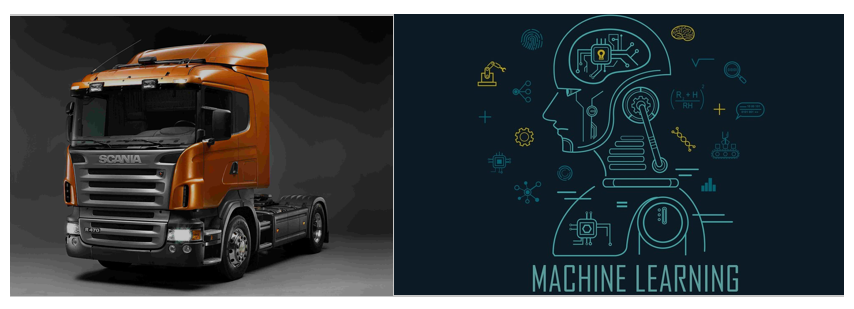

# Scania Trucks APS Failure Prediction using Machine Learning | By Atanu Kundu

### Problem Statement:
The Task is to predict whether a given failure is caused due to a specific component of the Air Pressure System. This may help in avoiding failure during truck operation and thereby reducing maintenance cost.

### Attribute Information:
Attribute Information:
The attribute names of the data have been anonymized for
proprietary reasons. It consists of both single numerical
counters and histograms consisting of bins with different
conditions. Typically the histograms have open-ended
conditions at each end. For example if we measuring
the ambient temperature 'T' then the histogram could
be defined with 4 bins where:

* bin 1 collect values for temperature T < -20  
* bin 2 collect values for temperature T >= -20 and T < 0
* bin 3 collect values for temperature T >= 0 and T < 20
* bin 4 collect values for temperature T > 20

| b1 | b2 | b3 | b4 |
-----------------------------
-20 0 20

The attributes are as follows: class, then
anonymized operational data. The operational data have
an identifier and a bin id, like 'Identifier_Bin'.
In total there are 171 attributes, of which 7 are
histogram variabels. Missing values are denoted by 'na'.

In [ ]:
!pip install lightgbm

In [ ]:
!pip install prettytable

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Import Required Packages

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
import seaborn as sns
import joblib
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from scipy.stats import uniform,randint
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from prettytable import PrettyTable
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle

## Reading the data

#### Training Set

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/CSV_FILE/aps_failure_training_set.csv",skiprows=20,na_values=["na"])

#### Testing Set

In [5]:
test_data = pd.read_csv("/content/drive/MyDrive/CSV_FILE/aps_failure_test_set.csv",skiprows=20,na_values=["na"])

#### Final Dataset

In [6]:
# joining both dataset and resetting index
data = pd.concat([train_data,test_data])

data.reset_index(inplace=True)

In [ ]:
# Removing index column fro datasset
data.drop('index',axis=1,inplace=True)
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [ ]:
row,columns=data.shape
print(f"Number of Observation in Adult Dataset: Rows->{row} And Columns->{columns}")

Number of Observation in Adult Dataset: Rows->76000 And Columns->171


### Basic Pre-Processing and Analysis
#### Class label Preprocessing

In [ ]:
def get_label(y):
  '''
  This function converts the class labels
  from 'neg' and 'pos' to 0 and 1  respectively
  '''
  return y.replace(['neg','pos'],[0,1])


In [ ]:
print(data['class'].unique())

['neg' 'pos']


In [ ]:
data['class'] = get_label(data['class'])

In [ ]:
print(data['class'].unique())

[0 1]


#### Class Distribution
Here, we will look into the distribution of our dataset. In ideal cases, we prefer a balanced dataset (equal number of positive and negative datapoints)

C:\Users\Atanu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


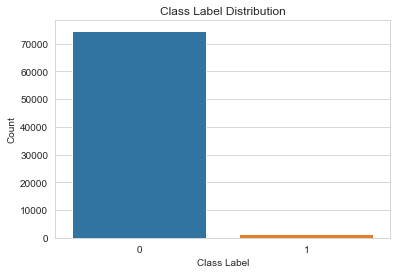

The Number of Positive Class Point is:  1375
The Number of Positive Class Point is:  74625


In [ ]:
# Plotting The Distribution of class label
sns.barplot(data['class'].unique(),data['class'].value_counts())
plt.title('Class Label Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print('The Number of Positive Class Point is: ',data['class'].value_counts()[1])
print('The Number of Positive Class Point is: ',data['class'].value_counts()[0])

#### Observation:

This dataset is highly imbalanced as the number of negative class points are much much more than the positive class points. We can choose to upsample the minority class datapoints, or use a modified classifier to tackle this problem.

### Checking for single value features
Out of the available features, the ones that have the same value for all datapoints do not hold much importance in improving performance of our model. Hence, we can discard those features.

We can remove the features that have standard deviation = 0

In [ ]:
def constant_value(df):
    '''
    This function returns a list of columns that have std. deviation of 0 meaning, all values are constant
    '''
    constant_value_features = []
    info = df.describe()
    for col in df.columns:
        if info[col]['std'] == 0:
            constant_value_features.append(col)
            
    df.drop(constant_value_features,axis=1,inplace=True)
    return df, constant_value_features

In [ ]:
data, dropped_columns = constant_value(data)

In [ ]:
print("The Features that are dropped due to having a constant value(0 std. dev.) are: ",dropped_columns)

The Features that are dropped due to having a constant value(0 std. dev.) are:  ['cd_000']


In [ ]:
print("Shape of our new Dataset: ",data.shape)

Shape of our new Dataset:  (76000, 170)


### Missing Values
Our dataset is known to have a high number of missing values. Lets have a closer look into it

In [ ]:
# Creating a Dictionary whose keys are the column names and values are the percentage of missing values
nan_count = {value:list(data.isnull().sum()*100/data.shape[0])[index] for index,value in enumerate(data.columns)}

In [ ]:
# Sorting the dictionary in descending order based on the percentage of missing values
nan_count = {k:v for k, v in sorted(nan_count.items(),key=lambda item: item[1], reverse=True)}

In [ ]:
nan_count

{'br_000': 82.09605263157894,
 'bq_000': 81.18815789473685,
 'bp_000': 79.55394736842105,
 'bo_000': 77.24868421052632,
 'ab_000': 77.22631578947369,
 'cr_000': 77.22631578947369,
 'bn_000': 73.31842105263158,
 'bm_000': 65.91447368421052,
 'bl_000': 45.39868421052632,
 'bk_000': 38.32631578947368,
 'ad_000': 24.792105263157893,
 'cf_000': 24.792105263157893,
 'cg_000': 24.792105263157893,
 'ch_000': 24.792105263157893,
 'co_000': 24.792105263157893,
 'ct_000': 23.060526315789474,
 'cu_000': 23.060526315789474,
 'cv_000': 23.060526315789474,
 'cx_000': 23.060526315789474,
 'cy_000': 23.060526315789474,
 'cz_000': 23.060526315789474,
 'da_000': 23.060526315789474,
 'db_000': 23.060526315789474,
 'dc_000': 23.060526315789474,
 'ec_00': 16.951315789473686,
 'cm_000': 16.388157894736842,
 'cl_000': 15.805263157894737,
 'ed_000': 15.805263157894737,
 'ak_000': 7.36578947368421,
 'ca_000': 7.318421052631579,
 'dm_000': 6.714473684210526,
 'df_000': 6.713157894736842,
 'dg_000': 6.71315789473

C:\Users\Atanu\AppData\Local\Temp/ipykernel_16212/2149047002.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs()))


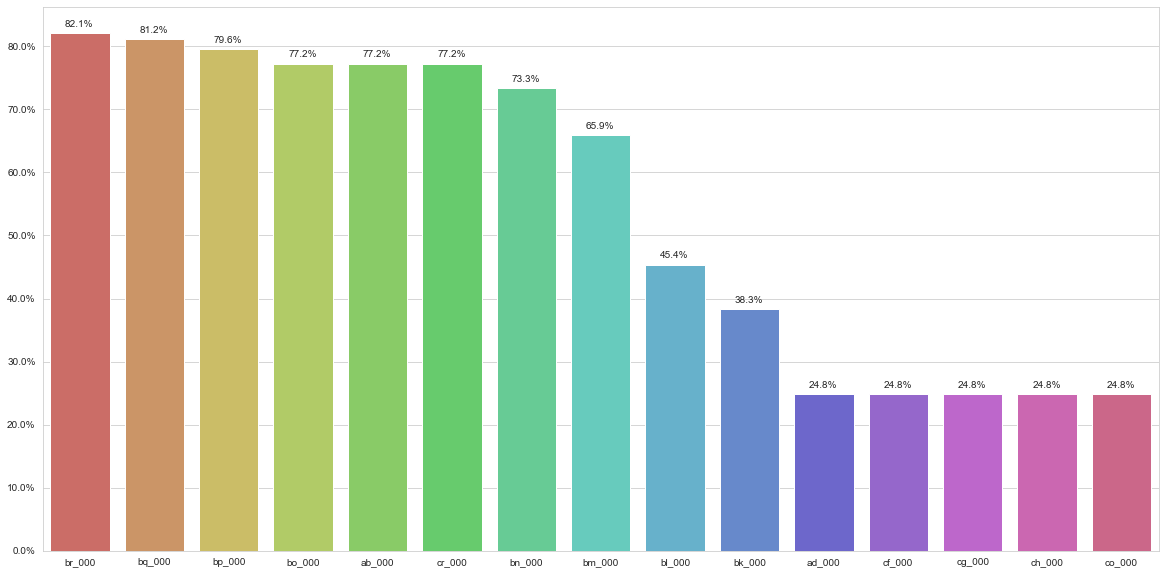

In [ ]:
# plotting a graph showing the top 15 features having highest percentage of missing values
sns.set_style(style="whitegrid")
plt.figure(figsize=(20,10))

# Bar plot
plot=sns.barplot(x=list(nan_count.keys())[:15],y=list(nan_count.values())[:15],palette="hls")

# Add annotation above each bar signifying their value
for p in plot.patches:
    plot.annotate('{:.1f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+1))

# Make y-axis more interpretable
plot.set_yticklabels(map('{:.1f}%'.format, plot.yaxis.get_majorticklocs()))
plt.show()

#### Observation:

* It is very evident that the some features have more than 50% missing values out of the total 60,000 datapoints. In the next section, we will see how to handle our missing data.

### Handling Missing Data
#### Dropping features and rows

In [ ]:
def remove_na(df,nan_feat):
    '''
    This function removes feature that having more than 70% missing data,
    and removes rows that have NA values from features have less than 5% missing data
    '''
    
    # Removing features having more than 70% NA
    df = df.dropna(axis=1,thresh=18000)
    
    # Removing rows having NA from above created dictionary of features
    df = df.dropna(subset=nan_feat)
    
    # Reset Index
    df = df.reset_index(drop=True)
    
    return df

In [ ]:
print("Old Shape of Dataset",data.shape)

Old Shape of Dataset (76000, 170)


In [ ]:
# List of features having less than 5% NA
na_5 = [k for k,v in nan_count.items() if v<5]

In [ ]:
data = remove_na(data,na_5)

In [ ]:
print("New Shape of Data",data.shape)

New Shape of Data (70872, 164)


In [ ]:
# Imputer object using Median and
# missing_values type for imputation

In [ ]:
imp = SimpleImputer(missing_values=np.nan,strategy='median')
for col in data.columns:
    data[col]=imp.fit_transform(data[col].values.reshape(-1,1))

#### Features Removed

In [ ]:
# creating a list of the top 7 features having highest number of missing values
na_70 = list(nan_count.keys())[:7]

# Total Removed Features
removed_features = na_70 + dropped_columns
print("Total Removed Features are:",removed_features)

Total Removed Features are: ['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'cd_000']


#### Drop the Duplicate Row

In [ ]:
data.duplicated().sum()

1

In [ ]:
data.drop_duplicates(keep='first',inplace=True)

In [ ]:
data.duplicated().sum()

0

#### Final Dataset

In [7]:
data=pd.read_csv("/content/drive/MyDrive/CSV_FILE/aps_failure_final.csv")
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head(3)

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,0.000000e+00,130.0,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0


In [9]:
data.shape

(70871, 164)

#### Seperating Data

In [9]:
X = data.drop('class',axis=1)
y = data['class']

#### Train Test Split

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=10)

## Logistic Regression

In [28]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [30]:
log_model.score(X_train,y_train)

0.9916219839142091

In [29]:
y_pred = log_model.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9902645502645503

In [33]:
ytrain_pred = log_model.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_model.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.8072378600997118
Logistic test roc-auc: 0.753410334609478


## Support Vector Classifier(SVC)

In [34]:
svc_model = SVC()

In [35]:
svc_model.fit(X_train,y_train)

SVC()

In [36]:
svc_model.score(X_train,y_train)

0.9886764498377311

In [37]:
y_pred = svc_model.predict(X_test)

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9883597883597883

## Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()

In [41]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [42]:
model.score(X_train,y_train)

1.0

In [43]:
y_predict=model.predict(X_test)

In [44]:
accuracy_score(y_test,y_predict)

0.992310405643739

In [46]:
ytrain_pred = model.predict_proba(X_train)
print('Decision train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = model.predict_proba(X_test)
print('Decision test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Decision train roc-auc: 1.0
Decision test roc-auc: 0.846379209655441


## Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
Rf_model=RandomForestClassifier()

In [48]:
Rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [49]:
Rf_model.score(X_train,y_train)

1.0

In [50]:
y_predict=Rf_model.predict(X_test)

In [51]:
accuracy_score(y_test,y_predict)

0.9954850088183421

In [52]:
ytrain_pred = Rf_model.predict_proba(X_train)
print('Random Forest train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = Rf_model.predict_proba(X_test)
print('Random Forest test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Random Forest train roc-auc: 1.0
Random Forest test roc-auc: 0.9864942789782192


## Adaboost Classifier

In [66]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier()

In [67]:
ada_model.fit(X_train,y_train)

AdaBoostClassifier()

In [68]:
ada_model.score(X_train,y_train)

0.9939678284182306

In [69]:
y_predict=ada_model.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_predict)

0.9935097001763669

In [71]:
ytrain_pred = ada_model.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = ada_model.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.9956894835646191
Adaboost test roc-auc: 0.9885955918932364


## Gradient Boost Classifier

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
model_gbm = GradientBoostingClassifier()

In [18]:
model_gbm.fit(X_train,y_train)

GradientBoostingClassifier()

In [19]:
model_gbm.score(X_train,y_train)

0.9974072244955552

In [20]:
y_pred_gbm = model_gbm.predict(X_test)

In [21]:
accuracy_score(y_test,y_pred_gbm)

0.9948500881834215

In [59]:
ytrain_pred = model_gbm.predict_proba(X_train)
print('Gradient Boost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = model_gbm.predict_proba(X_test)
print('Gradient Boost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Gradient Boost train roc-auc: 0.9882245581555335
Gradient Boost test roc-auc: 0.9853621871823156


## XG Boost Classifier

In [22]:
import xgboost

In [60]:
model_xgb = xgboost.XGBClassifier()

In [61]:
model_xgb.fit(X_train,y_train)

XGBClassifier()

In [62]:
model_xgb.score(X_train,y_train)

0.996895724566107

In [63]:
y_pred_xgb = model_xgb.predict(X_test)

In [64]:
accuracy_score(y_test,y_pred_xgb)

0.9953439153439153

In [65]:
ytrain_pred = model_xgb.predict_proba(X_train)
print('Extreme Gradient Boost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = model_xgb.predict_proba(X_test)
print('Extreme Gradient Boost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Extreme Gradient Boost train roc-auc: 0.9936274320535814
Extreme Gradient Boost test roc-auc: 0.989511387969632


#### No we will focus on selecting the best threshold for maximum accuracy

In [72]:
pred = []
for model in [log_model,model,Rf_model,ada_model,model_gbm,model_xgb]:
  pred.append(pd.Series(model.predict_proba(X_test)[:,1]))

final_prediction = pd.concat(pred,axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

Ensemble test roc-auc: 0.9898981247161119


In [73]:
pd.concat(pred,axis=1)

,0,1,2,3,4,5
0,5.238149e-05,0.450648,0.0,0.450648,0.000905,0.000394
1,4.195911e-02,0.446560,0.0,0.446560,0.000905,0.000323
2,1.904934e-03,0.456105,0.0,0.456105,0.000905,0.000352
3,1.225569e-02,0.431951,0.0,0.431951,0.000905,0.000301
4,3.522031e-03,0.455828,0.0,0.455828,0.000905,0.000480
...,...,...,...,...,...,...
14170,5.538699e-02,0.298392,0.0,0.298392,0.000905,0.000286
14171,6.239207e-03,0.447942,0.0,0.447942,0.000905,0.000390
14172,1.535266e-03,0.431113,0.0,0.431113,0.000905,0.000248
14173,1.493547e-04,0.450692,0.0,0.450692,0.000905,0.000502


In [74]:
final_prediction

0        0.150441
1        0.156051
2        0.152562
3        0.146227
4        0.152761
           ...   
14170    0.108894
14171    0.150569
14172    0.144152
14173    0.150490
14174    0.152379
Length: 14175, dtype: float64

In [75]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
thresholds

array([1.84277666, 0.84277666, 0.73136681, 0.73023673, 0.67506568,
       0.67485996, 0.65716605, 0.65213225, 0.58731904, 0.58624671,
       0.56619752, 0.56344743, 0.55340419, 0.54884092, 0.53725728,
       0.53492101, 0.53227403, 0.52834427, 0.52434085, 0.52355286,
       0.50901289, 0.50545178, 0.50461581, 0.5041723 , 0.50304652,
       0.49905209, 0.49109454, 0.47572554, 0.47314562, 0.47111861,
       0.46825958, 0.46725761, 0.45832753, 0.45652867, 0.45307833,
       0.44166252, 0.42733923, 0.41833807, 0.41705241, 0.4151352 ,
       0.41471161, 0.41097407, 0.40601984, 0.38670798, 0.38290784,
       0.37865245, 0.37851549, 0.37575387, 0.37249319, 0.35758046,
       0.35730667, 0.35443017, 0.35364763, 0.31543802, 0.31407353,
       0.30387788, 0.30359592, 0.29917764, 0.2985647 , 0.29830966,
       0.29471041, 0.29383164, 0.29253015, 0.2727289 , 0.27234113,
       0.23636307, 0.23559484, 0.23010152, 0.2288233 , 0.22831246,
       0.22795447, 0.22537662, 0.2251208 , 0.22289434, 0.22282

In [76]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
34,0.453078,0.995414
33,0.456529,0.995414
32,0.458328,0.995344
26,0.491095,0.995344
25,0.499052,0.995344


In [77]:
accuracy_ls

,thresholds,accuracy
34,0.453078,0.995414
33,0.456529,0.995414
32,0.458328,0.995344
26,0.491095,0.995344
25,0.499052,0.995344
...,...,...
107,0.154711,0.754638
108,0.154711,0.754568
109,0.148027,0.299965
110,0.148025,0.299894


In [78]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

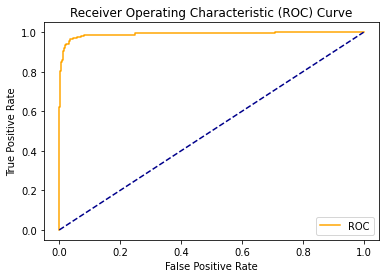

In [79]:
plot_roc_curve(fpr,tpr)